In [99]:
# general 
import pandas as pd 
import numpy as np 
import pickle
import math

import pyarrow as pa
import pyarrow.parquet as pq

# stats
from scipy import stats
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR

# tests
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import pacf, acf

# plotting
import seaborn as sns 
import plotly.express as px
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# settings
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (16, 8)
pd.options.plotting.backend = "plotly"

# ML
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

# darts
from darts import TimeSeries

In [100]:
# load all dataframes
cgm_df = pd.read_parquet("Parquet Files/cgm_df.parquet.gzip")

In [101]:
cgm_df.head()

,glucose
datetime,
2022-03-08 11:57:00,4.400000
2022-03-08 11:57:01,4.408333
2022-03-08 11:57:02,4.416667
2022-03-08 11:57:03,4.425000
2022-03-08 11:57:04,4.433333


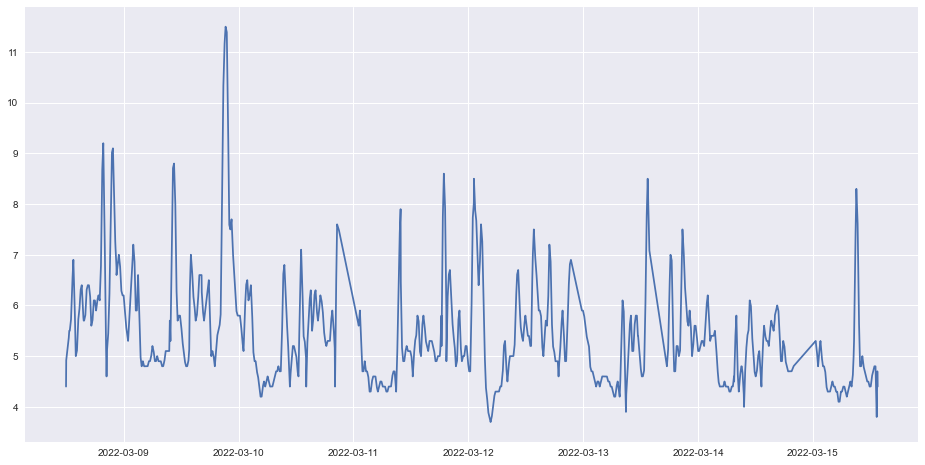

In [127]:
plt.plot(cgm_df)

In [103]:
cgm_df.describe()

,glucose
count,610441.000000
mean,5.490189
std,1.028178
min,3.700000
25%,4.791111
50%,5.256778
75%,5.974000
max,11.500000


In [238]:
daily_cgm_list = [group for name, group in cgm_df.groupby(pd.Grouper(freq="D"))]

In [239]:
# print first datetime and last datetime for all 8 days
def start_end_index(df):
    print(pd.DataFrame(
        {"Start Time": [day.index[0] for day in df],
        "End Time": [day.index[-1] for day in df]
        },
        index=[day for day in range(len(df))]
    ))

In [240]:
start_end_index(daily_cgm_list)

           Start Time            End Time
0 2022-03-08 11:57:00 2022-03-08 23:59:59
1 2022-03-09 00:00:00 2022-03-09 23:59:59
2 2022-03-10 00:00:00 2022-03-10 23:59:59
3 2022-03-11 00:00:00 2022-03-11 23:59:59
4 2022-03-12 00:00:00 2022-03-12 23:59:59
5 2022-03-13 00:00:00 2022-03-13 23:59:59
6 2022-03-14 00:00:00 2022-03-14 23:59:59
7 2022-03-15 00:00:00 2022-03-15 13:31:00


On day 1, cgm starts at 1157, on day 8, cgm ends at 1331. Drop both from list.

In [241]:
# concat all cgm values
full_day_cgm = pd.concat(daily_cgm_list[1:-1])

In [252]:
# resample and get minute values
full_day_min_cgm = full_day_cgm.resample('1T').median()

In [255]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    mse = metrics.mean_squared_error(y_true, y_pred)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    
    return {"rmse" : rmse,
            "mae": mae,
            "mse": mse,
            "mape": mape,
            "r2": r2}

In [249]:
# using sktime's excellent naive forecaster
from sktime.forecasting.naive import NaiveForecaster

import warnings
warnings.filterwarnings("ignore")

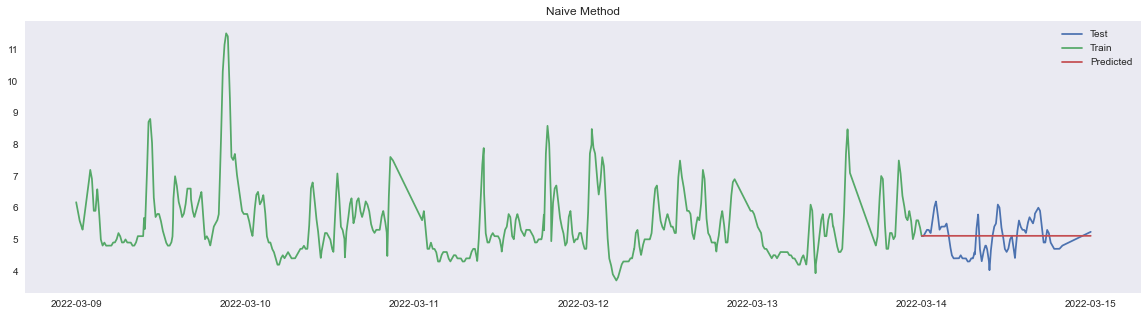

Mean RMSE for naive forecast: 0.9668291098464186.


0.9668291098464186

In [256]:
def naive_walk(data):
    count = 0
    errors = []
    data = data.reset_index()
    timeSeriesCrossVal = TimeSeriesSplit(n_splits=5) # no. splits = no. of days - 1
    
    # iterate through dataframe
    for train_lst, test_lst in timeSeriesCrossVal.split(data):
        
        # get train and test sets
        y_train = data.iloc[train_lst[0]:train_lst[-1]]
        y_test = data.iloc[test_lst[0]:test_lst[-1]]
        
        # fit
        forecaster = NaiveForecaster(strategy="last")
        forecaster.fit(y_train)
        
        # predict
        y_pred = forecaster.predict(test_lst[:-1])
        
        # compute errors
        err = timeseries_evaluation_metrics_func(y_test['glucose'].values,
                                                 y_pred['glucose'].values)
        errors.append(err['rmse'])
        
        # if last split, get the values for plotting
        count = count+1
        if count == 5:
            plt.figure(figsize=(20,5))
            plt.grid()
            plt.plot(y_test.set_index("datetime"), label="Test")
            plt.plot(y_train.set_index("datetime"), label="Train")
            plt.plot(pd.Series(y_pred['glucose'].values, index=y_test['datetime']), label="Predicted")
            plt.legend(loc='best')
            plt.title('Naive Method')
            plt.show()

    mean_rmse = np.mean(errors)
    
    print(f"Mean RMSE for naive forecast: {mean_rmse}.")
    return mean_rmse
        
naive_walk(full_day_min_cgm['glucose'])

With naive forecast done, proceed to classical models:
- Pure ARIMA for glucose
- ARIMAX with HRV exogenous variables
- VARMA with HRV exogenous variables

Using the DARTS library for forecasting

In [272]:
# augmented dickey fuller test first
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.\n")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.\n")

In [258]:
# run augmented dickey-fuller test to detect stationarity
adfuller_test(full_day_min_cgm['glucose'], name="Glucose")

    Augmented Dickey-Fuller Test on "Glucose" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.6944
 No. Lags Chosen       = 37
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.



In [265]:
from darts import TimeSeries
darts_cgm = TimeSeries.from_dataframe(full_day_min_cgm)

In [274]:
darts_cgm

<TimeSeries (DataArray) (datetime: 8640, component: 1, sample: 1)>
array([[[6.17016667]],

       [[6.15016667]],

       [[6.13016667]],

       ...,

       [[5.23433753]],

       [[5.23613609]],

       [[5.23793465]]])
Coordinates:
  * datetime   (datetime) datetime64[ns] 2022-03-09 ... 2022-03-14T23:59:00
  * component  (component) object 'glucose'
Dimensions without coordinates: sample

In [273]:
def arima_walk(data):
    count = 0
    errors = []
    timeSeriesCrossVal = TimeSeriesSplit(n_splits=5) # no. splits = no. of days - 1
    
    # iterate through dataframe
    for train_lst, test_lst in timeSeriesCrossVal.split(data):
        
        
    #     # get train and test sets
    #     y_train = data.iloc[train_lst[0]:train_lst[-1]]
    #     y_test = data.iloc[test_lst[0]:test_lst[-1]]
        
    #     # fit
    #     forecaster = NaiveForecaster(strategy="last")
    #     forecaster.fit(y_train)
        
    #     # predict
    #     y_pred = forecaster.predict(test_lst[:-1])
        
    #     # compute errors
    #     err = timeseries_evaluation_metrics_func(y_test['glucose'].values,
    #                                              y_pred['glucose'].values)
    #     errors.append(err['rmse'])
        
    #     # if last split, get the values for plotting
    #     count = count+1
    #     if count == 5:
    #         plt.figure(figsize=(20,5))
    #         plt.grid()
    #         plt.plot(y_test.set_index("datetime"), label="Test")
    #         plt.plot(y_train.set_index("datetime"), label="Train")
    #         plt.plot(pd.Series(y_pred['glucose'].values, index=y_test['datetime']), label="Predicted")
    #         plt.legend(loc='best')
    #         plt.title('Naive Method')
    #         plt.show()

    # mean_rmse = np.mean(errors)
    
    # print(f"Mean RMSE for naive forecast: {mean_rmse}.")
    # return mean_rmse
        
arima_walk(darts_cgm)

1440 1440
2880 1440
4320 1440
5760 1440
7200 1440


In [ ]:
# load all pickle files
with open('Pickle Files/all_list_pkl', 'rb') as f:
    daily_df_features = pickle.load(f)

In [ ]:
daily_df_features[0].head()

In [107]:
# for each day of readings, join the cgm values to hrv features
def join_glucose_and_features(glucose_df_list, feature_df_list, on, how):
    l = []
    for day, values in enumerate(glucose_df_list):
        all = pd.merge(left=glucose_df_list[day],
                       right=feature_df_list[day],
                       on=on,
                       how=how)
        l.append(all)
    return l

In [111]:
all_df = join_glucose_and_features(daily_cgm_list,
                                   daily_df_features,
                                   on="datetime",
                                   how="outer")

In [115]:
# print first datetime and last datetime for all 8 days
def start_end_index(df):
    print(pd.DataFrame(
        {"Start Time": [day.index[0] for day in df],
        "End Time": [day.index[-1] for day in df]
        },
        index=[day for day in range(len(df))]
    ))

           Start Time            End Time
0 2022-03-08 11:57:00 2022-03-08 23:59:59
1 2022-03-09 00:00:00 2022-03-09 23:59:59
2 2022-03-10 00:00:00 2022-03-10 23:59:59
3 2022-03-11 00:00:00 2022-03-11 23:59:59
4 2022-03-12 00:00:00 2022-03-12 23:59:59
5 2022-03-13 00:00:00 2022-03-13 23:59:59
6 2022-03-14 00:00:00 2022-03-14 23:59:59
7 2022-03-15 00:00:00 2022-03-15 22:35:57


- Latest start time: 09:46:36 -> 09:50:00 (excluding day 1, to be dropped)
- Earliest end time: 21:56:55 -> 21:50:00 (excluding day 6, to be dropped)

Total: 12 hours of data

In [14]:
# truncate input days by latest start time and earliest 
# end time so that we can create multiple discrete sequences
trunc_all_df = [all_df[1].truncate(before=pd.Timestamp('2022-03-09 09:50:00'),
                                    after=pd.Timestamp('2022-03-09 21:50:00')),
                all_df[2].truncate(before=pd.Timestamp('2022-03-10 09:50:00'),
                                    after=pd.Timestamp('2022-03-10 21:50:00')),
                all_df[3].truncate(before=pd.Timestamp('2022-03-11 09:50:00'),
                                    after=pd.Timestamp('2022-03-11 21:50:00')),
                all_df[4].truncate(before=pd.Timestamp('2022-03-12 09:50:00'),
                                    after=pd.Timestamp('2022-03-12 21:50:00')),
                all_df[5].truncate(before=pd.Timestamp('2022-03-13 09:50:00'),
                                    after=pd.Timestamp('2022-03-13 21:50:00')),
                all_df[6].truncate(before=pd.Timestamp('2022-03-14 09:50:00'),
                                    after=pd.Timestamp('2022-03-14 21:50:00'))]

In [110]:
def resample_indiv_col(ls_of_df):
    l = []
    for i, v in enumerate(ls_of_df):
        d1 = trunc_all_df[i].resample('1T').median()
        d1.interpolate(method='time', inplace=True)
        l.append(d1)
    return l

all_df_min = resample_indiv_col(trunc_all_df)

In [37]:
# flatten out entire list and truncate all dateframes
df = pd.concat(all_df_min)

In [38]:
df.tail()

,glucose,mean_nni,sdnn,sdsd,nni_50,pnni_50,nni_20,pnni_20,rmssd,median_nni,...,max_hr,min_hr,std_hr,lf,hf,lf_hf_ratio,lfnu,hfnu,total_power,vlf
datetime,,,,,,,,,,,,,,,,,,,,,
2022-03-14 21:46:00,4.998771,990.164639,83.826932,37.697296,41.0,13.643965,155.0,51.324503,37.699299,992.75,...,74.719801,49.019608,5.292347,2088.102448,245.598670,8.504839,89.478972,10.521028,3444.193808,1066.983986
2022-03-14 21:47:00,5.000525,948.387302,100.783946,34.189996,37.0,11.783439,151.0,48.095219,34.194217,954.00,...,81.521739,49.019608,6.998559,1720.085982,185.926770,9.068630,90.068162,9.931838,3307.492546,1338.338397
2022-03-14 21:48:00,5.002308,903.503012,109.822419,29.008006,29.0,8.761329,143.0,42.900302,29.041277,907.00,...,92.592593,52.219321,8.622546,1206.379356,162.303240,7.638696,88.424179,11.575821,3226.158467,1844.538806
2022-03-14 21:49:00,5.004062,858.276099,105.913450,29.012137,29.0,8.309456,145.0,41.547278,29.021054,844.00,...,92.592593,51.620635,8.520552,1165.241393,138.668221,8.464224,89.433760,10.566240,3306.599020,2025.620758
2022-03-14 21:50:00,5.005036,854.638177,105.014081,29.898847,29.0,8.285714,155.0,44.285714,29.902699,841.00,...,92.592593,49.059689,8.407414,1488.921829,161.167104,9.238373,90.232823,9.767177,5915.893342,4265.804409


In [39]:
df.shape

(4324, 24)

In [40]:
# df has lots of duplicates, drop them, keep last value
# df = df[~df.index.duplicated(keep='first')]

In [41]:
# no duplicates
df.index.duplicated().sum()

0

In [20]:
df.describe()

,glucose,mean_nni,sdnn,sdsd,nni_50,pnni_50,nni_20,pnni_20,rmssd,median_nni,...,max_hr,min_hr,std_hr,lf,hf,lf_hf_ratio,lfnu,hfnu,total_power,vlf
count,4324.000000,4324.000000,4324.000000,4324.000000,4324.000000,4324.000000,4324.000000,4324.000000,4324.000000,4324.000000,...,4324.000000,4324.000000,4324.000000,4324.000000,4324.000000,4324.000000,4324.000000,4324.000000,4324.000000,4324.000000
mean,5.756140,1019.857189,119.947799,47.437981,62.344010,22.574125,159.774283,56.444951,47.443625,1032.073659,...,91.832688,48.378041,8.190237,2221.354836,370.779704,6.894480,84.351536,15.648464,7227.255822,4628.525886
std,1.034927,178.568458,46.668031,15.213100,29.355489,11.902436,34.783676,16.688297,15.213042,196.539634,...,57.916432,9.888364,4.580441,1444.046947,280.180684,3.746277,8.429197,8.429197,4566.354614,3599.603901
min,4.412292,365.826033,11.663264,4.096607,0.000000,0.000000,0.000000,0.000000,4.096857,364.000000,...,51.502146,27.919963,1.360347,1.230569,1.580640,0.300080,23.081649,2.663878,14.899880,8.188998
25%,5.083319,903.376044,86.198963,38.378295,43.000000,14.157931,152.000000,48.787744,38.382618,881.000000,...,74.349442,43.636364,5.286748,1246.075040,220.582965,4.406948,81.490750,10.460107,3857.643475,1950.154818
50%,5.506790,1050.645961,113.607557,47.248941,64.000000,23.050246,168.000000,61.409396,47.249106,1083.000000,...,82.987552,46.296296,7.442813,1942.226051,321.933818,6.181656,86.063168,13.936832,6390.262304,3697.498177
75%,6.097083,1157.277695,148.534618,56.505667,80.000000,30.406941,180.000000,67.830893,56.509052,1185.500000,...,94.191523,49.382716,10.248839,2820.729865,456.400531,8.560131,89.539893,18.509250,9596.859845,6355.390993
max,11.496667,1447.473430,361.499516,116.587565,277.000000,60.386473,330.000000,85.650224,116.587606,1477.500000,...,1276.595745,148.148148,70.691322,13091.632859,4820.176658,36.539261,97.336122,76.918351,34679.844051,28699.984134


In [21]:
# fn to check for NaNs and zeroes
def check_for_nans_zeroes(data):
    zero_count = [(data[col] == 0).sum() for col in data]
    NaN_count = [data[col].isnull().sum() for col in data]
    
    return pd.DataFrame(
    {'Number of Zeroes': zero_count, 'Number of Nans' : NaN_count},
    index=data.columns)
    
check_for_nans_zeroes(df)

,Number of Zeroes,Number of Nans
glucose,0,0
mean_nni,0,0
sdnn,0,0
sdsd,0,0
nni_50,48,0
pnni_50,48,0
nni_20,3,0
pnni_20,3,0
rmssd,0,0
median_nni,0,0


In [154]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.\n")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.\n")

In [155]:
# run augmented dickey-fuller test on all columns to detect stationarity
def adf_harness(data):
    for colname, colvalues in data.iteritems():
        adfuller_test(colvalues, name=colname)
         
adf_harness(y_train)

    Augmented Dickey-Fuller Test on "glucose" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.0213
 No. Lags Chosen       = 15
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.

    Augmented Dickey-Fuller Test on "mean_nni" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.4444
 No. Lags Chosen       = 16
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.

    Augmented Dickey-Fuller Test on "sdnn" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    

All columns are stationary even without differencing.

In [157]:
def create_corr_plot(series, plot_pacf=False):
    corr_array = pacf(series.dropna(), alpha=0.05) if plot_pacf else acf(series.dropna(), alpha=0.05)
    lower_y = corr_array[1][:,0] - corr_array[0]
    upper_y = corr_array[1][:,1] - corr_array[0]

    fig = go.Figure()
    [fig.add_scatter(x=(x,x), y=(0,corr_array[0][x]), mode='lines',line_color='#3f3f3f') 
     for x in range(len(corr_array[0]))]
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=corr_array[0], mode='markers', marker_color='#1f77b4',
                   marker_size=12)
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=upper_y, mode='lines', line_color='rgba(255,255,255,0)')
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=lower_y, mode='lines',fillcolor='rgba(32, 146, 230,0.3)',
            fill='tonexty', line_color='rgba(255,255,255,0)')
    fig.update_traces(showlegend=False)
    fig.update_xaxes(range=[-1,42])
    fig.update_yaxes(zerolinecolor='#000000')
    
    title='Partial Autocorrelation (PACF)' if plot_pacf else 'Autocorrelation (ACF)'
    fig.update_layout(title=title)
    fig.show()

In [159]:
# look at pacf and acf plots
create_corr_plot(y_train['glucose'])
create_corr_plot(y_train['glucose'], plot_pacf=True)

In [161]:
# viz glucose levels
fig = px.scatter(y_train['glucose'])
fig.show()

In [ ]:
# 25% of the dataset will be used for testing
y_train, y_test = temporal_train_test_split(combined_df, test_size=0.25)

print(f"Training set shape: {y_train.shape}")
print(f"Test set shape: {y_test.shape}")

In [ ]:
pd.DataFrame(
    [(combined_df[col] == 0).sum() for col in y_train],
    index=combined_df.columns,
    columns=['Number of Zeroes']
)

In [ ]:
# create a logged and first order differenced df
y_train_log_diff = np.log(
    y_train.drop(
        ['nni_50',
        'pnni_50',
        'nni_20',
        'pnni_20'],
        axis=1)
    ).diff().dropna()

Stationarity checks with ADFuller

In [ ]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.\n")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.\n")

In [ ]:
# run augmented dickey-fuller test on all columns to detect stationarity
def adf_harness(data):
    for colname, colvalues in data.iteritems():
        adfuller_test(colvalues, name=colname)
         
adf_harness(y_train_log_diff)

In [ ]:
fig = px.scatter(y_train_log_diff)
fig.show()

#### Interpreting time series correlation
Refer to:
>https://stats.stackexchange.com/questions/133155/how-to-use-pearson-correlation-correctly-with-time-series

Check out the bi-directional relationship between the independent variables and the dependent variables. Some other causuality tests can be tried, i.e. Granger Causality Test to investigate causality between two time series variables.

Granger casuality testing only applies to stationary intervals.

- Null hypothesis: HRV feature (x) does not explain variation in (y) glucose.
- Alternative hypothesis: HRV feature (x) has an effect on glucose with a 95% confidence interval that a change in x causes a response in 'glucose' (y)

In [ ]:
# running a chi^2 test on each column of the df
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False, maxlag=12):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [ ]:
grangers_causation_matrix(y_train_log_diff, variables=y_train_log_diff.columns)

## Cointegration test:

To find out how many lagging terms are required for a TS to become stationary.
With two or more TS, they are considered cointegrated if they have a statistically significant relationship.
This means, there exists a linear combination of them that has an order of integration less than that of the individual series.

- https://en.wikipedia.org/wiki/Cointegration
- http://www-stat.wharton.upenn.edu/~steele/Courses/434/434Context/Co-integration/Murray93DrunkAndDog.pdf
- https://en.m.wikipedia.org/wiki/Johansen_test
- https://en.wikipedia.org/wiki/Error_correction_model

null hypothesis: no cointegrating equations, alternate hypothesis: at least 1 cointegrating relationship

In [ ]:
def cointegration_test(data, alpha=0.05):
    out = coint_johansen(data, -1, 5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(data.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [ ]:
cointegration_test(y_train_log_diff[['glucose', 'rmssd', 'sdnn', 'cvnni', 'lf', 'hf']])

In [ ]:
y_train_log_diff.info()

Get a persistent (naive) forecast to evaluate model performance

In [ ]:
from sktime.forecasting.naive import NaiveForecaster

In [ ]:
forecaster = NaiveForecaster(strategy="drift")
forecaster.fit(y_train_log_diff)

In [ ]:
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# predict
	yhat = history[-1]
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

Glucose forecasts using ARIMA

In [ ]:
def create_corr_plot(series, plot_pacf=False):
    '''This function plots PACF and ACF plots using plotly's backend'''
    corr_array = pacf(series.dropna(), alpha=0.05) if plot_pacf else acf(series.dropna(), alpha=0.05)
    lower_y = corr_array[1][:,0] - corr_array[0]
    upper_y = corr_array[1][:,1] - corr_array[0]

    fig = go.Figure()
    [fig.add_scatter(x=(x,x), y=(0,corr_array[0][x]), mode='lines',line_color='#3f3f3f') 
     for x in range(len(corr_array[0]))]
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=corr_array[0], mode='markers', marker_color='#1f77b4',
                   marker_size=12)
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=upper_y, mode='lines', line_color='rgba(255,255,255,0)')
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=lower_y, mode='lines',fillcolor='rgba(32, 146, 230,0.3)',
            fill='tonexty', line_color='rgba(255,255,255,0)')
    fig.update_traces(showlegend=False)
    fig.update_xaxes(range=[-1,42])
    fig.update_yaxes(zerolinecolor='#000000')
    
    title='Partial Autocorrelation (PACF)' if plot_pacf else 'Autocorrelation (ACF)'
    fig.update_layout(title=title)
    fig.show()
    
create_corr_plot(y_train_log_diff['glucose'], plot_pacf=False)
create_corr_plot(y_train_log_diff['glucose'], plot_pacf=True)

Using a library, DARTS for TS forecasting

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(y_train_log_diff['glucose'].values, order=(1,1,2))
model_fit = model.fit()
print(model_fit.summary())

In [ ]:
model = VAR(y_train_log_diff[['glucose', 'rmssd']])
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')